In [218]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, mean_absolute_error
import itertools


In [349]:
def solve_joint_distribution_iterate(pa, pb, num=50):
    
    """
    Iterates over all possible values of c and k within their ranges
    to solve the joint probability distribution.

    Parameters:
        pa: dict
            Marginal probabilities
        pb: dict
            Marginal probabilities 
        num: float
            number of points for iterating over c and k.

    Returns:
        list: A list of valid joint distributions that satisfy all constraints.
    """
    # Extract marginal probabilities
    pa00, pa10, pa01, pa11 = pa[(0, 0)], pa[(1, 0)], pa[(0, 1)], pa[(1, 1)]
    pb00, pb10, pb01, pb11 = pb[(0, 0)], pb[(1, 0)], pb[(0, 1)], pb[(1, 1)]
    
    # Bounds for c
    lower_bound_c = max(0, pb00 - pa10)
    upper_bound_c = min(1, pa00, pb00)
    
    # Bounds for k
    lower_bound_k = max(0, pb10 - pa11)
    upper_bound_k = min(1, pa01, pb10)

    # List to store valid joint distributions
    valid_joint_distributions = []
    
    # Iterate over all possible values of c and k
    c_values = np.linspace(lower_bound_c, upper_bound_c, num)
    k_values =  np.linspace(lower_bound_k, upper_bound_k, num)
    
    for c in c_values:
        for k in k_values:
            try:
                # Compute joint probabilities
                p000 = c
                p001 = pa00 - c
                p100 = pb00 - c
                p101 = pa10 - pb00 + c
                p010 = k
                p011 = pa01 - k
                p110 = pb10 - k
                p111 = pa11 - pb10 + k

                joint_distribution = {
                    "p000": p000, "p001": p001, "p100": p100, "p101": p101,
                    "p010": p010, "p011": p011, "p110": p110, "p111": p111
                }
                
                # Ensure all probabilities are positive and not zero
                if any(value <= 0.01 for value in joint_distribution.values()):
                    continue  # Skip this combination if any probability is <= 0
                
                # Ensure all constraints are met
                total_sum = sum(joint_distribution.values())
                all_positive = all(value >= 0 for value in joint_distribution.values())
                
                # Marginal constraints
                pa_computed = {
                    (0, 0): p000 + p001,
                    (1, 0): p100 + p101,
                    (0, 1): p010 + p011,
                    (1, 1): p110 + p111,
                }
                pb_computed = {
                    (0, 0): p000 + p100,
                    (1, 0): p001 + p101,
                    (0, 1): p010 + p110,
                    (1, 1): p011 + p111,
                }
                pa_valid = all(abs(pa[key] - pa_computed[key]) < 1e-9 for key in pa)
                pb_valid = all(abs(pb[key] - pb_computed[key]) < 1e-9 for key in pb)
                
                # If all conditions are satisfied, add to the list
                if abs(total_sum - 1) < 1e-9 and all_positive and pa_valid and pb_valid:
                    valid_joint_distributions.append(joint_distribution)
            
            except AssertionError:
                # Ignore invalid combinations
                continue
    
    return valid_joint_distributions

In [346]:

def sample_data_from_distribution(joint_distribution, n_samples=1000):
    """
    Samples data points from a given joint probability distribution.

    Parameters:
        joint_distribution: dict
            A joint distribution dictionary.
        n_samples: int
            Number of data points to sample.

    Returns:
        pd.DataFrame: A DataFrame with columns X1, X2, X3.
    """
    # Extract probabilities and outcomes
    outcomes = [(0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1),
                (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1)]
    probabilities = [joint_distribution[f"p{''.join(map(str, outcome))}"] for outcome in outcomes]
    
    # Sample indices based on probabilities
    sampled_indices = np.random.choice(len(outcomes), size=n_samples, p=probabilities)
    
    # Create the dataset
    data = np.array([outcomes[i] for i in sampled_indices])
    return pd.DataFrame(data, columns=["X1", "X2", "X3"])


In [347]:
def calculate_fairness_metrics(y_true, y_pred, protected_attr):
    """
    Calculates fairness metrics based on predictions and the protected attribute.

    Parameters:
        y_true: array-like
            Ground truth labels.
        y_pred: array-like
            Predicted labels.
        protected_attr: array-like
            Protected attribute values.

    Returns:
        dict: Fairness metrics.
    """
    # Convert to arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    protected_attr = np.array(protected_attr)
    
    # Initialize metrics
    metrics = {
        "disparate_impact": {},
        "equal_opportunity": {}}
    
    group_mask_0 = protected_attr == 0
    group_mask_1 = protected_attr == 1
    metrics["disparate_impact"] = (np.mean(y_pred[group_mask_0]) + 0.1) / (np.mean(y_pred[group_mask_1]) + 0.1)
    metrics["equal_opportunity"] = np.mean(y_pred[group_mask_0][y_true[group_mask_0] == 1]) - np.mean(y_pred[group_mask_1][y_true[group_mask_1] == 1])
    
    return metrics

def regression_fairness_pipeline(valid_distributions, n_samples=1000):
    
    """
    Full pipeline to sample data, fit regression models, and calculate fairness metrics.

    Parameters:
        valid_distributions: list
            List of valid joint distributions.
        n_samples: int
            Number of data points per dataset.

    Returns:
        list: Fairness metrics for each joint distribution.
    """
    all_metrics = []
    
    for joint_distribution in valid_distributions:
        # Step 1: Sample data
        data = sample_data_from_distribution(joint_distribution, n_samples=n_samples)
        
        # Step 2: Train regression model
        X = data[["X1", "X2"]]
        y = data["X3"]
        model = LogisticRegression()
        model.fit(X, y)
        y_pred = model.predict(X)
        
        # Step 3: Calculate fairness metrics
        fairness_metrics = calculate_fairness_metrics(y, y_pred, data["X1"])
        all_metrics.append(fairness_metrics)
    
    return all_metrics

def get_min_max_fairness_metrics(fairness_results):
    
    """
    Extracts the min and max of the fairness metrics from the results.

    Parameters:
        fairness_results: list
            List of fairness metrics for each joint distribution.

    Returns:
        dict: Minimum and maximum values of fairness metrics.
    """
    
    min_max_metrics = {
        "disparate_impact": {"min": float('inf'), "max": -float('inf')},
        "equal_opportunity": {"min": float('inf'), "max": -float('inf')},    }
    
    for metrics in fairness_results:
        # Update min and max for each metric
        min_max_metrics["disparate_impact"]["min"] = min(min_max_metrics["disparate_impact"]["min"], metrics["disparate_impact"])
        min_max_metrics["disparate_impact"]["max"] = max(min_max_metrics["disparate_impact"]["max"], metrics["disparate_impact"])
        
        min_max_metrics["equal_opportunity"]["min"] = min(min_max_metrics["equal_opportunity"]["min"], metrics["equal_opportunity"])
        min_max_metrics["equal_opportunity"]["max"] = max(min_max_metrics["equal_opportunity"]["max"], metrics["equal_opportunity"])
        
    
    return min_max_metrics

In [ ]:
# Add fairness metrics for each joint distribution in the DataFrame
def add_fairness_metrics_to_dataframe(df, n_samples=10000):
    """
    Add fairness metrics to the DataFrame containing joint distributions.

    Parameters:
        df: pd.DataFrame
            DataFrame with columns `pa`, `pb`, and `distribution`.
        n_samples: int
            Number of samples to generate from each joint distribution.

    Returns:
        pd.DataFrame: Updated DataFrame with fairness metrics.
    """
    # List to store fairness metrics for each row
    fairness_metrics_list = []

    for idx, row in df.iterrows():
        # Get the joint distribution
        joint_distribution = row["distribution"]

        # Step 3: Compute fairness metrics
        metrics = regression_fairness_pipeline(joint_distribution, n_samples=1000)

        # Append metrics to the list
        fairness_metrics_list.append(metrics)

    # Add the fairness metrics as a new column
    df["fairness_metrics"] = fairness_metrics_list
    return df


# Apply to the results DataFrame
df_results_with_fairness = add_fairness_metrics_to_dataframe(df_results)

# Display the updated DataFrame
print(df_results_with_fairness)

In [353]:
def generate_marginals(range_values):
    """
    Generate a range of valid marginal probability distributions for testing.

    Parameters:
        range_values: list of float
            List of probabilities to use for generating marginals.

    Returns:
        list: A list of marginal distributions.
    """
    marginals = []
    for pa00 in range_values:
        for pa10 in range_values:
            for pa01 in range_values:
                pa11 = 1 - (pa00 + pa10 + pa01)
                if pa11 >= 0:
                    marginals.append({
                        (0, 0): pa00, (1, 0): pa10, (0, 1): pa01, (1, 1): pa11
                    })
    return marginals

# Example implementation to test the function
range_values = np.linspace(0.1, 0.4, 5)  # Generate probabilities in the range [0.1, 0.4]
marginals_pa = generate_marginals(range_values)
marginals_pb = generate_marginals(range_values)


marginals_pa

# List to store DataFrame rows
rows = []

# Solve for valid joint distributions
for pa in marginals_pa:
    for pb in marginals_pb:
        # Ensure marginal x2 matches
        if np.isclose(pa[(0, 1)] + pa[(1, 1)], pb[(0, 1)] + pb[(1, 1)], atol=1e-6):
            distributions = solve_joint_distribution_iterate(pa, pb, num=20)
            
            # Compute fairness metrics
            fairness_metrics = regression_fairness_pipeline(distributions, n_samples=100)
            
            # Add rows for each valid distribution
            for dist, metrics in zip(distributions, fairness_metrics):
                rows.append({
                    "pa": pa,
                    "pb": pb,
                    "distribution": dist,
                    "fairness_metrics": metrics
                })

# Convert to DataFrame
df_results = pd.DataFrame(rows)

# Display the DataFrame
print(df_results)


            

/Users/varsha/opt/anaconda3/envs/joint-dist-toy/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/varsha/opt/anaconda3/envs/joint-dist-toy/lib/python3.11/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/varsha/opt/anaconda3/envs/joint-dist-toy/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/varsha/opt/anaconda3/envs/joint-dist-toy/lib/python3.11/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/varsha/opt/anaconda3/envs/joint-dist-toy/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/U

KeyboardInterrupt: 

In [311]:
# Example marginals
pa = {(0, 0): 0.3, (1, 0): 0.2, (0, 1): 0.1, (1, 1): 0.4}
pb = {(0, 0): 0.4, (1, 0): 0.1, (0, 1): 0.1, (1, 1): 0.4}

# Compute valid joint distributions
valid_distributions = solve_joint_distribution_iterate(pa, pb, num=50)

print(f"Found {len(valid_distributions)} valid distributions.")
for dist in valid_distributions[:5]:  # Display first 5 results
    print(dist)

0.2
0.3
0
0.1
[0.2        0.20204082 0.20408163 0.20612245 0.20816327 0.21020408
 0.2122449  0.21428571 0.21632653 0.21836735 0.22040816 0.22244898
 0.2244898  0.22653061 0.22857143 0.23061224 0.23265306 0.23469388
 0.23673469 0.23877551 0.24081633 0.24285714 0.24489796 0.24693878
 0.24897959 0.25102041 0.25306122 0.25510204 0.25714286 0.25918367
 0.26122449 0.26326531 0.26530612 0.26734694 0.26938776 0.27142857
 0.27346939 0.2755102  0.27755102 0.27959184 0.28163265 0.28367347
 0.28571429 0.2877551  0.28979592 0.29183673 0.29387755 0.29591837
 0.29795918 0.3       ]
[0.         0.00204082 0.00408163 0.00612245 0.00816327 0.01020408
 0.0122449  0.01428571 0.01632653 0.01836735 0.02040816 0.02244898
 0.0244898  0.02653061 0.02857143 0.03061224 0.03265306 0.03469388
 0.03673469 0.03877551 0.04081633 0.04285714 0.04489796 0.04693878
 0.04897959 0.05102041 0.05306122 0.05510204 0.05714286 0.05918367
 0.06122449 0.06326531 0.06530612 0.06734694 0.06938776 0.07142857
 0.07346939 0.0755102  0

In [312]:
# compute fairness metrics
fairness_results = regression_fairness_pipeline(valid_distributions, n_samples=10000)

print(f"Fairness metrics for {len(fairness_results)} joint distributions:")
for idx, metrics in enumerate(fairness_results[:5]):  # Show first 5 results
    print(f"Distribution {idx + 1}: {metrics}")

Fairness metrics for 1600 joint distributions:
Distribution 1: {'disparate_impact': np.float64(0.45340411019913585), 'equal_opportunity': np.float64(-0.4820617168291671)}
Distribution 2: {'disparate_impact': np.float64(0.4873745503351475), 'equal_opportunity': np.float64(-0.4458105342552724)}
Distribution 3: {'disparate_impact': np.float64(0.4787602972748828), 'equal_opportunity': np.float64(-0.4551560492900003)}
Distribution 4: {'disparate_impact': np.float64(0.45760108337745237), 'equal_opportunity': np.float64(-0.48400127883664956)}
Distribution 5: {'disparate_impact': np.float64(0.46004120410474253), 'equal_opportunity': np.float64(-0.48935769414506386)}


In [326]:
# Initialize a dictionary to collect all p* values
ps_values = {}

# Iterate over each dictionary in the data
for entry in valid_distributions:
    for key, value in entry.items():
        if key not in ps_values:
            ps_values[key] = []
        ps_values[key].append(float(value))  # Convert to standard float for clarity

# Print the organized dictionary
for key, values in ps_values.items():
    print(f"{key}: {values}")


p000: [0.21020408163265308, 0.21020408163265308, 0.21020408163265308, 0.21020408163265308, 0.21020408163265308, 0.21020408163265308, 0.21020408163265308, 0.21020408163265308, 0.21020408163265308, 0.21020408163265308, 0.21020408163265308, 0.21020408163265308, 0.21020408163265308, 0.21020408163265308, 0.21020408163265308, 0.21020408163265308, 0.21020408163265308, 0.21020408163265308, 0.21020408163265308, 0.21020408163265308, 0.21020408163265308, 0.21020408163265308, 0.21020408163265308, 0.21020408163265308, 0.21020408163265308, 0.21020408163265308, 0.21020408163265308, 0.21020408163265308, 0.21020408163265308, 0.21020408163265308, 0.21020408163265308, 0.21020408163265308, 0.21020408163265308, 0.21020408163265308, 0.21020408163265308, 0.21020408163265308, 0.21020408163265308, 0.21020408163265308, 0.21020408163265308, 0.21020408163265308, 0.2122448979591837, 0.2122448979591837, 0.2122448979591837, 0.2122448979591837, 0.2122448979591837, 0.2122448979591837, 0.2122448979591837, 0.21224489795

In [314]:

def calculate_conditional_probability(ps_values):
    """
    Calculate the conditional probability p(x3 = 1 | x1 = 0) from the given joint distribution `ps_values`.
    If the denominator is 0, return np.nan (Not a Number).
    
    Args:
    ps_values (dict): Dictionary containing joint distribution probabilities for each key.
    
    Returns:
    list: A list of conditional probabilities for each entry in `ps_values`.
    """
    
    # Calculate p(x3 = 1 and x1 = 0) -> sum of p001, p011, p101, p111 for each entry
    p_x3_1_and_x1_0_values = [
        ps_values['p001'][i] + ps_values['p011'][i] 
        for i in range(len(ps_values['p001']))
    ]
    
    # Calculate p(x1 = 0) -> sum of p000, p001, p010, p011 for each entry
    p_x1_0_values = [
        ps_values['p000'][i] + ps_values['p001'][i] + ps_values['p010'][i] + ps_values['p011'][i]
        for i in range(len(ps_values['p000']))
    ]
    
    # Calculate conditional probability p(x3 = 1 | x1 = 0) for each entry
    p_x3_1_given_x1_0_values = []
    
    for i in range(len(p_x1_0_values)):
        # Check for zero in the denominator
        if p_x1_0_values[i] == 0:
            p_x3_1_given_x1_0_values.append(np.nan)  # Return np.nan for undefined conditional probability
        else:
            p_x3_1_given_x1_0_values.append(p_x3_1_and_x1_0_values[i] / p_x1_0_values[i])
    
    return p_x3_1_given_x1_0_values


# Calculate conditional probabilities
conditional_probabilities = calculate_conditional_probability(ps_values)

print("p(x3 = 1 | x1 = 0) for each entry:", conditional_probabilities)


p(x3 = 1 | x1 = 0) for each entry: [0.44897959183673464, 0.4438775510204081, 0.4387755102040815, 0.43367346938775503, 0.4285714285714285, 0.42346938775510196, 0.4183673469387754, 0.41326530612244894, 0.4081632653061224, 0.4030612244897958, 0.39795918367346933, 0.39285714285714274, 0.38775510204081626, 0.3826530612244897, 0.3775510204081632, 0.37244897959183665, 0.36734693877551017, 0.36224489795918363, 0.35714285714285704, 0.35204081632653056, 0.34693877551020397, 0.3418367346938775, 0.33673469387755095, 0.3316326530612244, 0.3265306122448979, 0.3214285714285713, 0.3163265306122448, 0.31122448979591827, 0.3061224489795918, 0.3010204081632652, 0.29591836734693866, 0.2908163265306122, 0.28571428571428564, 0.2806122448979591, 0.2755102040816325, 0.27040816326530603, 0.2653061224489795, 0.260204081632653, 0.2551020408163265, 0.2499999999999999, 0.44387755102040805, 0.43877551020408156, 0.43367346938775503, 0.4285714285714285, 0.42346938775510196, 0.4183673469387754, 0.413265306122449, 0.40

In [330]:
import numpy as np

def calculate_conditional_probability(ps_values):
    """
    Calculate the conditional probabilities p(x3 = 1 | x1 = 0) and p(x3 = 1 | x1 = 1) 
    from the given joint distribution `ps_values`.
    If the denominator is 0, return np.nan (Not a Number).
    
    Args:
    ps_values (dict): Dictionary containing joint distribution probabilities for each key.
    
    Returns:
    dict: A dictionary with conditional probabilities for both x1 = 0 and x1 = 1.
    """
    
    # Calculate p(x3 = 1 and x1 = 0) -> sum of p001, p011, p101, p111 for each entry
    p_x3_1_and_x1_0_values = [
        ps_values['p001'][i] + ps_values['p011'][i]
        for i in range(len(ps_values['p001']))
    ]
    
    # Calculate p(x3 = 1 and x1 = 1) -> sum of p100, p101, p110, p111 for each entry
    p_x3_1_and_x1_1_values = [
        ps_values['p101'][i] + ps_values['p111'][i]
        for i in range(len(ps_values['p100']))
    ]
    
    # Calculate p(x1 = 0) -> sum of p000, p001, p010, p011 for each entry
    p_x1_0_values = [
        ps_values['p000'][i] + ps_values['p001'][i] + ps_values['p010'][i] + ps_values['p011'][i]
        for i in range(len(ps_values['p000']))
    ]
    
    # Calculate p(x1 = 1) -> sum of p100, p101, p110, p111 for each entry
    p_x1_1_values = [
        ps_values['p100'][i] + ps_values['p101'][i] + ps_values['p110'][i] + ps_values['p111'][i]
        for i in range(len(ps_values['p100']))
    ]
    
    # Calculate conditional probabilities p(x3 = 1 | x1 = 0) and p(x3 = 1 | x1 = 1)
    p_x3_1_given_x1_0_values = []
    p_x3_1_given_x1_1_values = []
    
    for i in range(len(p_x1_0_values)):
        # Check for zero in the denominators
        if p_x1_0_values[i] == 0:
            p_x3_1_given_x1_0_values.append(np.nan)  # Return np.nan for undefined conditional probability
        else:
            p_x3_1_given_x1_0_values.append(p_x3_1_and_x1_0_values[i] / p_x1_0_values[i])
        
        if p_x1_1_values[i] == 0:
            p_x3_1_given_x1_1_values.append(np.nan)  # Return np.nan for undefined conditional probability
        else:
            p_x3_1_given_x1_1_values.append(p_x3_1_and_x1_1_values[i] / p_x1_1_values[i])
    
    # Return a dictionary of the conditional probabilities
    return {
        'p_x3_1_given_x1_0': p_x3_1_given_x1_0_values,
        'p_x3_1_given_x1_1': p_x3_1_given_x1_1_values
    }


# Calculate conditional probabilities
conditional_probabilities = calculate_conditional_probability(ps_values)

print("p(x3 = 1 | x1 = 0) for each entry:", conditional_probabilities['p_x3_1_given_x1_0'])
print("p(x3 = 1 | x1 = 1) for each entry:", conditional_probabilities['p_x3_1_given_x1_1'])


p(x3 = 1 | x1 = 0) for each entry: [0.44897959183673464, 0.4438775510204081, 0.4387755102040815, 0.43367346938775503, 0.4285714285714285, 0.42346938775510196, 0.4183673469387754, 0.41326530612244894, 0.4081632653061224, 0.4030612244897958, 0.39795918367346933, 0.39285714285714274, 0.38775510204081626, 0.3826530612244897, 0.3775510204081632, 0.37244897959183665, 0.36734693877551017, 0.36224489795918363, 0.35714285714285704, 0.35204081632653056, 0.34693877551020397, 0.3418367346938775, 0.33673469387755095, 0.3316326530612244, 0.3265306122448979, 0.3214285714285713, 0.3163265306122448, 0.31122448979591827, 0.3061224489795918, 0.3010204081632652, 0.29591836734693866, 0.2908163265306122, 0.28571428571428564, 0.2806122448979591, 0.2755102040816325, 0.27040816326530603, 0.2653061224489795, 0.260204081632653, 0.2551020408163265, 0.2499999999999999, 0.44387755102040805, 0.43877551020408156, 0.43367346938775503, 0.4285714285714285, 0.42346938775510196, 0.4183673469387754, 0.413265306122449, 0.40

In [316]:
# Get min and max of all fairness metrics
min_max_metrics = get_min_max_fairness_metrics(fairness_results)

# Display min and max for each fairness metric
print("Minimum and Maximum of Fairness Metrics:")
print(f"Disparate Impact- Min: {min_max_metrics['disparate_impact']['min']}, Max: {min_max_metrics['disparate_impact']['max']}")
print(f"Equal Opportunity Diff - Min: {min_max_metrics['equal_opportunity']['min']}, Max: {min_max_metrics['equal_opportunity']['max']}")

Minimum and Maximum of Fairness Metrics:
Disparate Impact- Min: 0.12746972594008923, Max: 0.48790566863743096
Equal Opportunity Diff - Min: -0.9116245831348261, Max: 0.1254861403611921


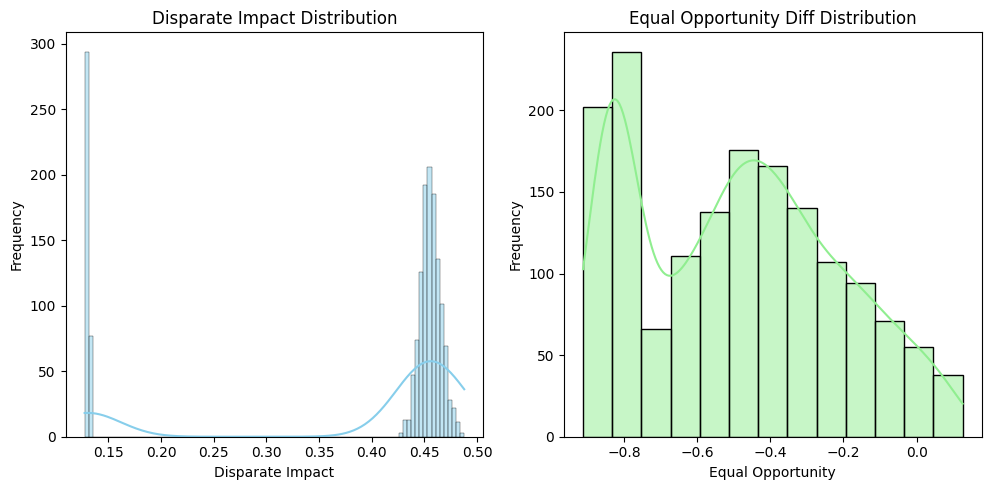

In [317]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_fairness_metrics_distributions(fairness_results):
    """
    Plots the distributions of fairness metrics.

    Parameters:
        fairness_results: list
            List of fairness metrics for each joint distribution.
    """
    # Extract the fairness metrics for each distribution
    disparate_impact = [metrics["disparate_impact"] for metrics in fairness_results]
    equal_opportunity = [metrics["equal_opportunity"] for metrics in fairness_results]
    
    # Set up the plot
    plt.figure(figsize=(15, 5))
    
    # Plot Demographic Parity distribution
    plt.subplot(1, 3, 1)
    sns.histplot(disparate_impact, kde=True, color='skyblue')
    plt.title('Disparate Impact Distribution')
    plt.xlabel('Disparate Impact')
    plt.ylabel('Frequency')
    
    # Plot Equal Opportunity distribution
    plt.subplot(1, 3, 2)
    sns.histplot(equal_opportunity, kde=True, color='lightgreen')
    plt.title('Equal Opportunity Diff Distribution')
    plt.xlabel('Equal Opportunity')
    plt.ylabel('Frequency')
    
    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# Example usage
#valid_distributions = solve_joint_distribution_iterate(pa, pb, step=0.01)
#fairness_results = regression_fairness_pipeline(valid_distributions, n_samples=1000)

# Plot the distributions of fairness metrics
plot_fairness_metrics_distributions(fairness_results)


In [318]:
disparate_impact = [metrics["disparate_impact"] for metrics in fairness_results]
equal_opportunity = [metrics["equal_opportunity"] for metrics in fairness_results]

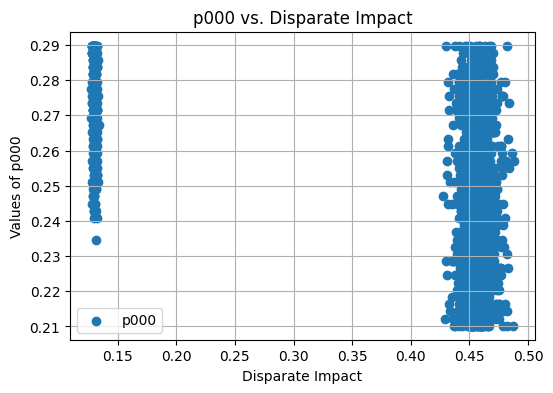

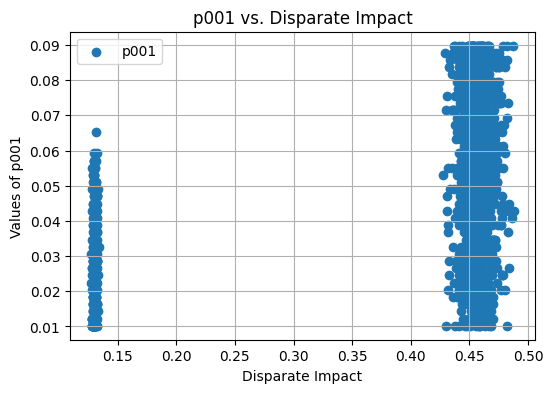

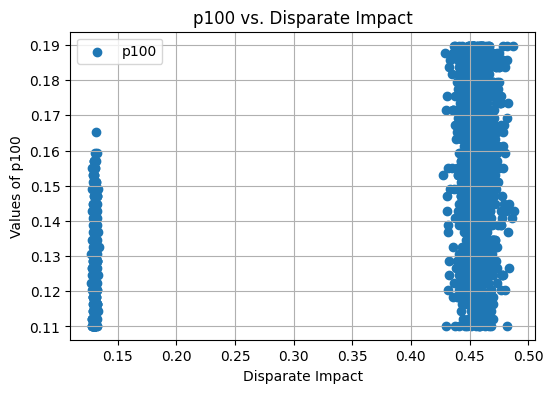

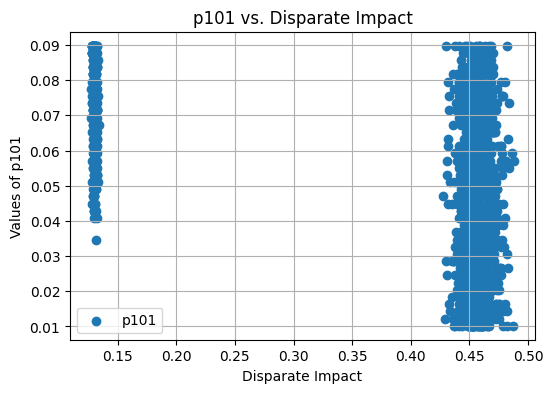

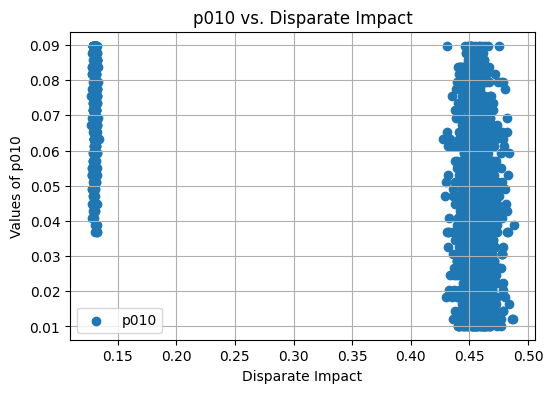

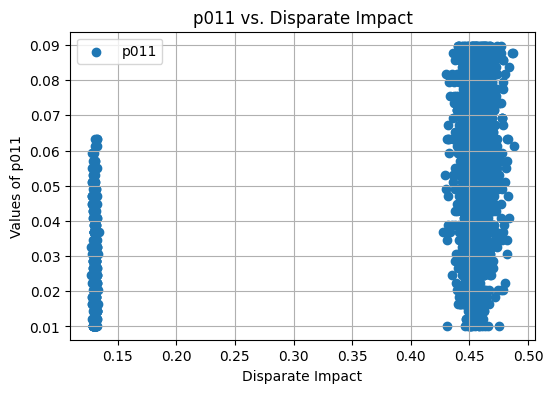

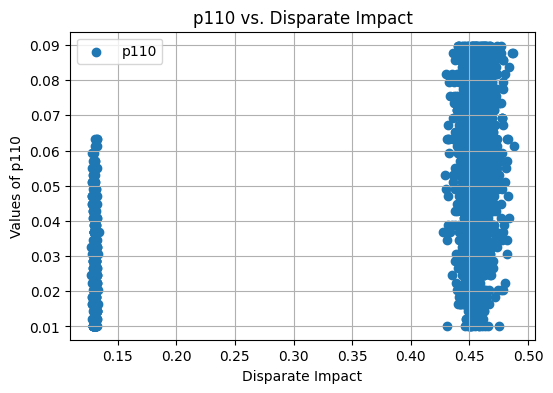

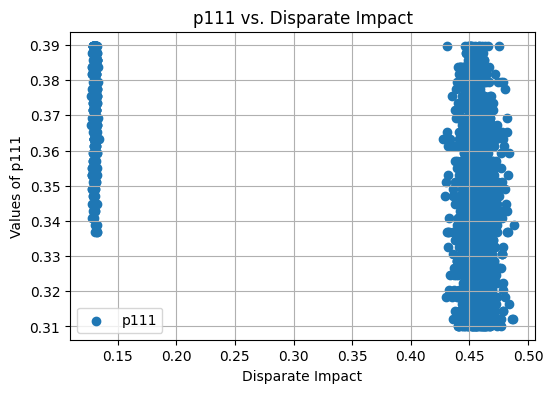

In [319]:
# Create separate scatter plots for each p-variable
for p_key, values in ps_values.items():
    plt.figure(figsize=(6, 4))
    plt.scatter(disparate_impact, values, label=p_key)
    plt.xlabel('Disparate Impact')
    plt.ylabel(f'Values of {p_key}')
    plt.title(f'{p_key} vs. Disparate Impact')
    plt.grid(True)
    plt.legend()
    plt.show()

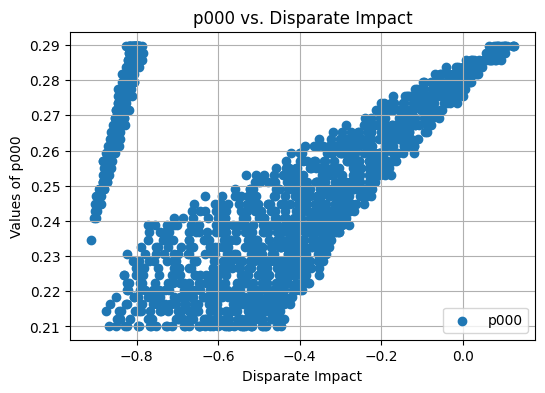

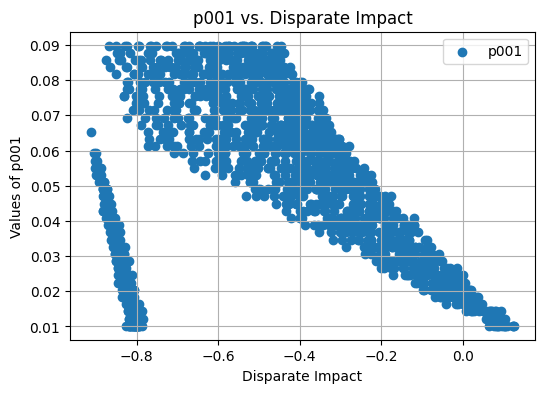

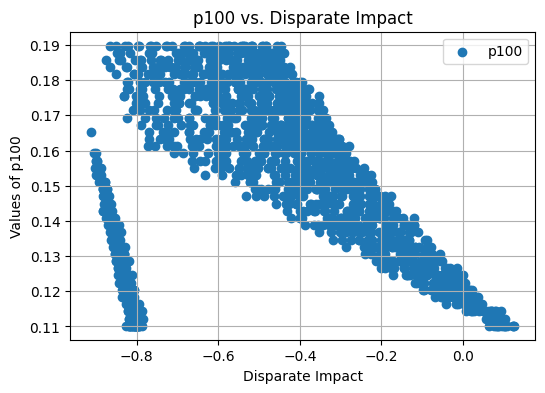

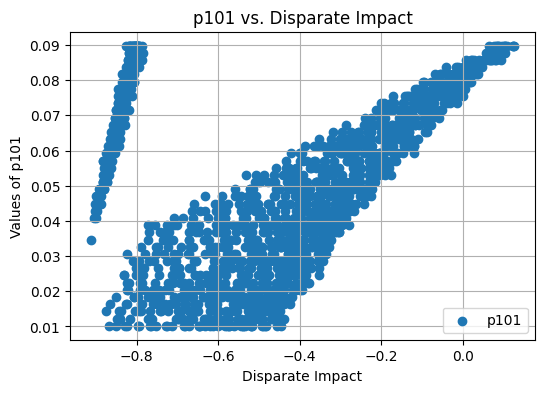

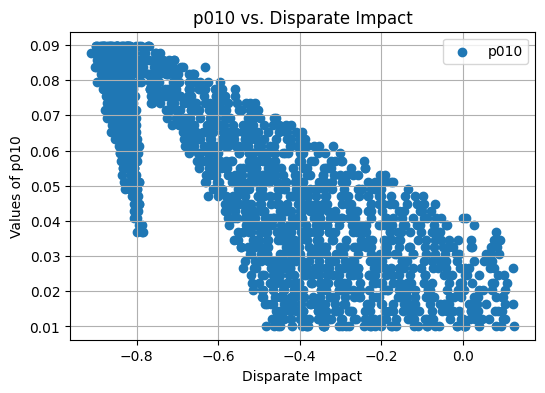

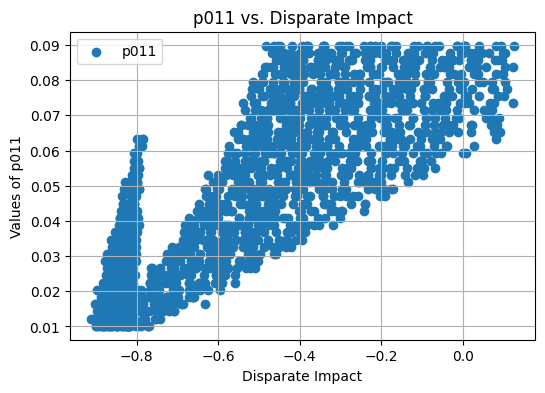

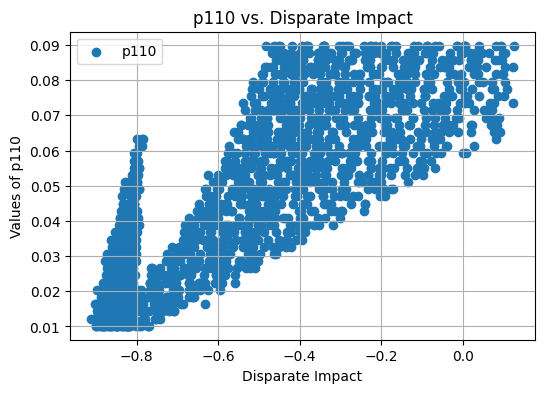

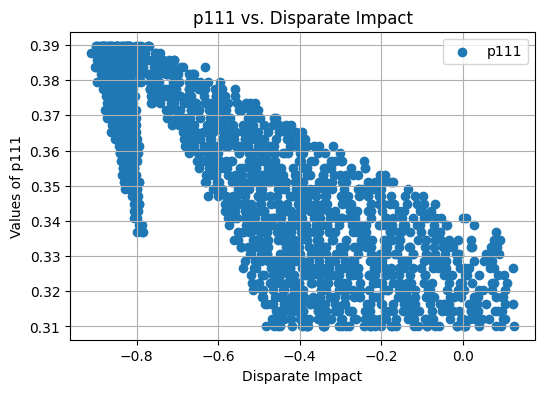

In [320]:
# Create separate scatter plots for each p-variable
for p_key, values in ps_values.items():
    plt.figure(figsize=(6, 4))
    plt.scatter(equal_opportunity, values, label=p_key)
    plt.xlabel('Disparate Impact')
    plt.ylabel(f'Values of {p_key}')
    plt.title(f'{p_key} vs. Disparate Impact')
    plt.grid(True)
    plt.legend()
    plt.show()

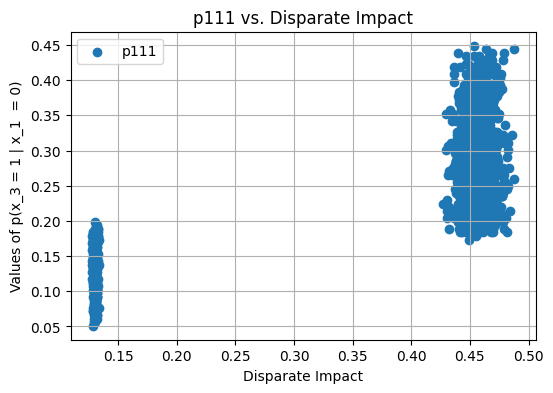

In [322]:
# Create separate scatter plots for each p-variable
plt.figure(figsize=(6, 4))
plt.scatter(disparate_impact, conditional_probabilities, label=p_key)
plt.xlabel('Disparate Impact')
plt.ylabel(f'Values of p(x_3 = 1 | x_1  = 0)')
plt.title(f'{p_key} vs. Disparate Impact')
plt.grid(True)
plt.legend()
plt.show()

In [262]:
for result in conditional_results[:5]:  # Display first 5 results
    print(f"P(X_3 = 1 | X_1 = 0): {result['p_x3_1_given_x1_0']}")
    print(f"P(X_3 = 1 | X_1 = 1): {result['p_x3_1_given_x1_1']}")
    print(f"Ratio: {result['ratio']}")
    print()
    
result['p_x3_1_given_x1_0']

P(X_3 = 1 | X_1 = 0): 0.25
P(X_3 = 1 | X_1 = 1): 0.6666666666666666
Ratio: 0.375

P(X_3 = 1 | X_1 = 0): 0.25
P(X_3 = 1 | X_1 = 1): 0.6666666666666666
Ratio: 0.375

P(X_3 = 1 | X_1 = 0): 0.25
P(X_3 = 1 | X_1 = 1): 0.6666666666666667
Ratio: 0.37499999999999994

P(X_3 = 1 | X_1 = 0): 0.25
P(X_3 = 1 | X_1 = 1): 0.6666666666666667
Ratio: 0.37499999999999994

P(X_3 = 1 | X_1 = 0): 0.25
P(X_3 = 1 | X_1 = 1): 0.6666666666666667
Ratio: 0.37499999999999994



np.float64(0.25)

In [254]:
conditional_results

(np.float64(0.3750000000000001),
 np.float64(0.37499999999999994),
 [{'joint_distribution': {'p000': np.float64(0.2),
    'p001': np.float64(0.09999999999999998),
    'p100': np.float64(0.2),
    'p101': np.float64(0.0),
    'p010': np.float64(0.0),
    'p011': np.float64(0.1),
    'p110': np.float64(0.1),
    'p111': np.float64(0.30000000000000004)},
   'p_x3_1_given_x1_0': np.float64(0.25),
   'p_x3_1_given_x1_1': np.float64(0.6666666666666666),
   'ratio': np.float64(0.375)},
  {'joint_distribution': {'p000': np.float64(0.2),
    'p001': np.float64(0.09999999999999998),
    'p100': np.float64(0.2),
    'p101': np.float64(0.0),
    'p010': np.float64(0.00101010101010101),
    'p011': np.float64(0.09898989898989899),
    'p110': np.float64(0.09898989898989899),
    'p111': np.float64(0.30101010101010106)},
   'p_x3_1_given_x1_0': np.float64(0.25),
   'p_x3_1_given_x1_1': np.float64(0.6666666666666666),
   'ratio': np.float64(0.375)},
  {'joint_distribution': {'p000': np.float64(0.2),


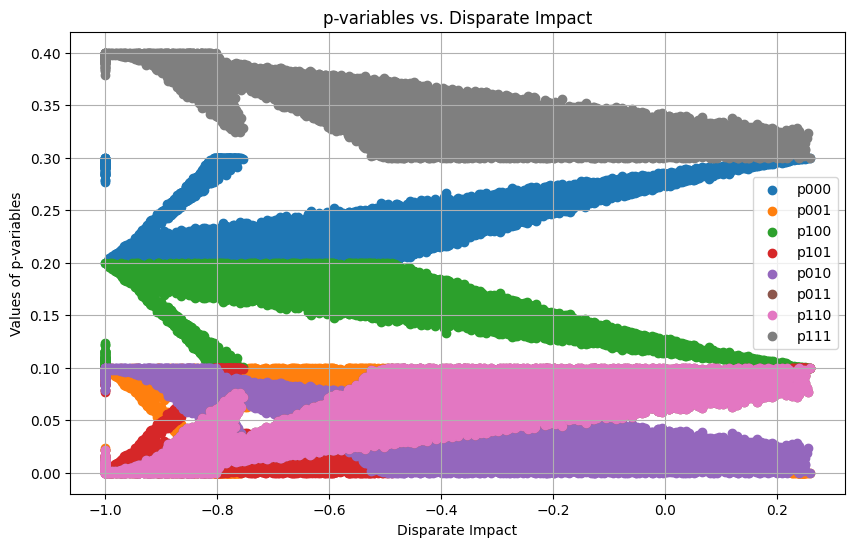

In [249]:
# Plot each p-variable against disparate_impact
plt.figure(figsize=(10, 6))

for p_key, values in ps_values.items():
    plt.scatter(equal_opportunity, values, marker='o', label=p_key)

# Add labels, title, and legend
plt.xlabel('Disparate Impact')
plt.ylabel('Values of p-variables')
plt.title('p-variables vs. Disparate Impact')
plt.legend()
plt.grid(True)
plt.show()

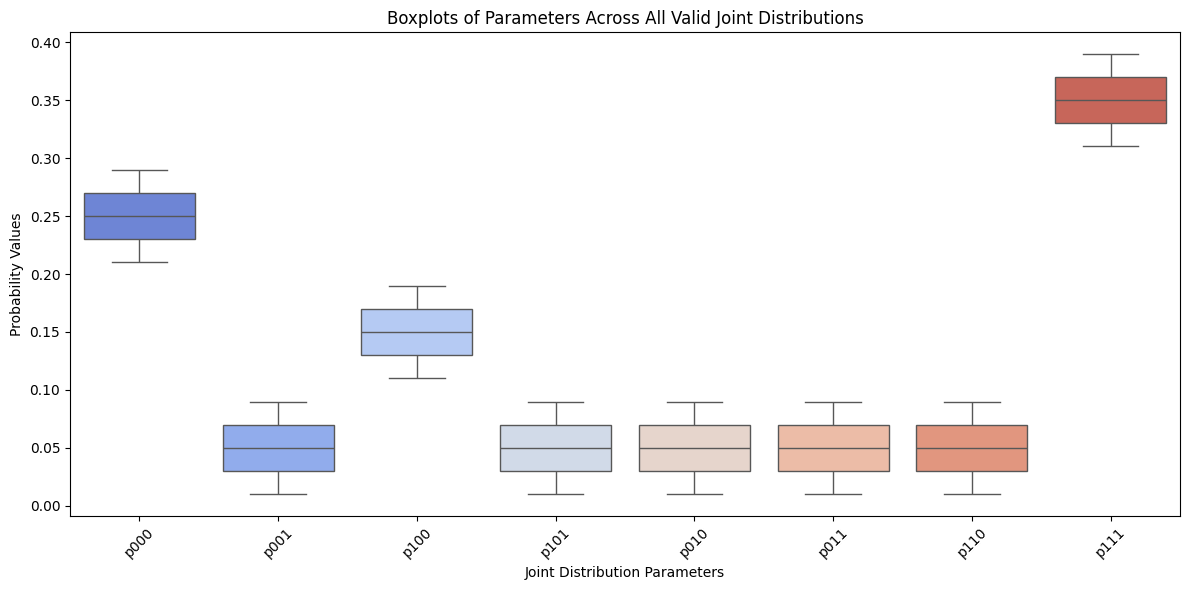

In [331]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_all_joint_parameters_as_boxplots(valid_distributions):
    """
    Plots boxplots for each parameter (e.g., p000, p001, ...) across all valid joint distributions.

    Parameters:
        valid_distributions: list of dicts
            List of valid joint distributions, where each distribution is a dictionary.
    """
    # Extract parameter names
    parameter_names = ["p000", "p001", "p100", "p101", "p010", "p011", "p110", "p111"]
    
    # Collect values for each parameter
    data = {param: [] for param in parameter_names}
    for dist in valid_distributions:
        for param in parameter_names:
            data[param].append(dist[param])
    
    # Prepare data for plotting
    plot_data = []
    labels = []
    
    for param, values in data.items():
        plot_data.append(values)
        labels.append(param)
    
    # Create boxplot
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=plot_data, palette="coolwarm")
    plt.xticks(ticks=range(len(labels)), labels=labels, rotation=45)
    plt.title("Boxplots of Parameters Across All Valid Joint Distributions")
    plt.xlabel("Joint Distribution Parameters")
    plt.ylabel("Probability Values")
    plt.tight_layout()
    plt.show()

# Call the function to plot
plot_all_joint_parameters_as_boxplots(valid_distributions)


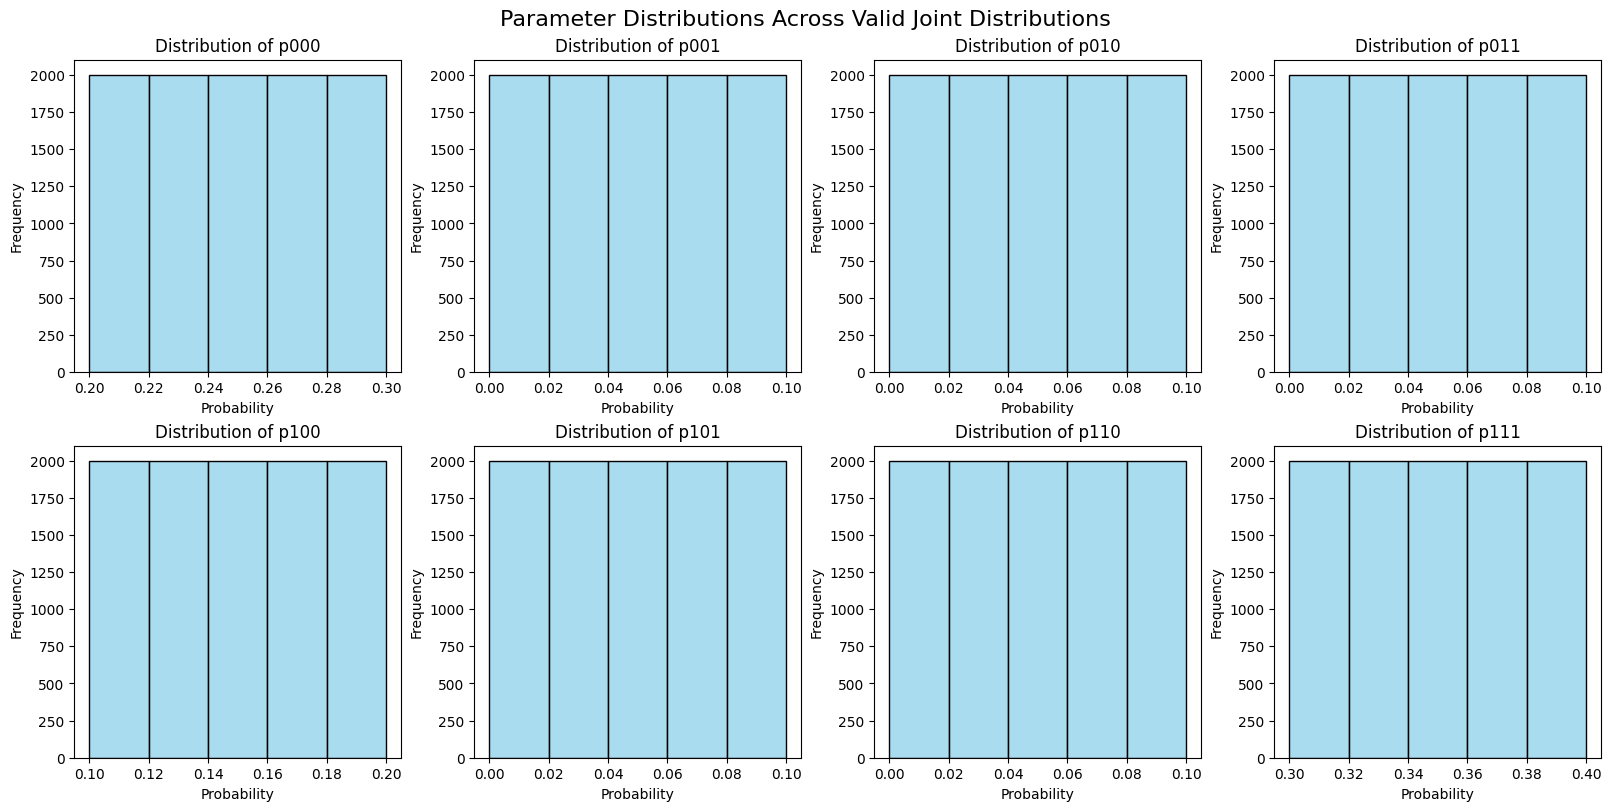

In [279]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_parameter_distributions(valid_distributions):
    """
    Plots the distributions of each parameter in the joint distributions.

    Parameters:
        valid_distributions: list
            List of valid joint distributions.
    """
    outcomes = ["p000", "p001", "p010", "p011", "p100", "p101", "p110", "p111"]
    num_outcomes = len(outcomes)
    
    # Extract each parameter's values from all distributions
    param_values = {outcome: [dist[outcome] for dist in valid_distributions] for outcome in outcomes}
    
    # Create subplots
    fig, axes = plt.subplots(2, 4, figsize=(16, 8), constrained_layout=True)
    axes = axes.flatten()
    
    for i, outcome in enumerate(outcomes):
        sns.histplot(param_values[outcome], bins=5, ax=axes[i], color="skyblue", alpha=0.7)
        axes[i].set_title(f"Distribution of {outcome}", fontsize=12)
        axes[i].set_xlabel("Probability")
        axes[i].set_ylabel("Frequency")

    
    # Overall title
    fig.suptitle("Parameter Distributions Across Valid Joint Distributions", fontsize=16)
    plt.show()

# Example usage
plot_parameter_distributions(valid_distributions)


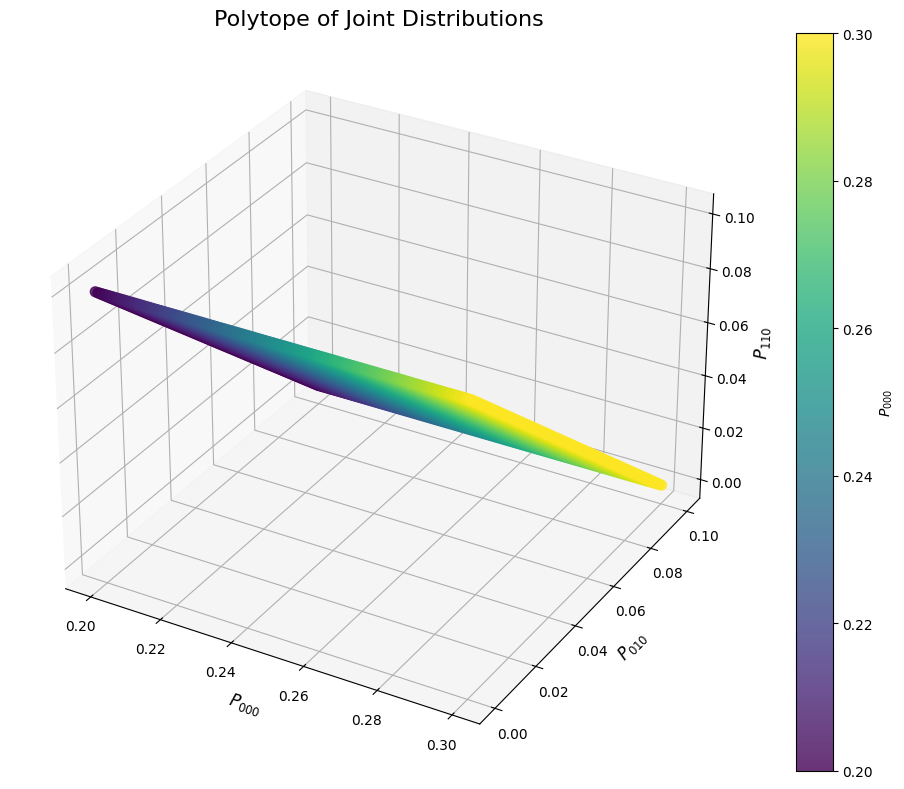

In [175]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_joint_distribution_polytope(valid_distributions):
    """
    Plots the polytope formed by the valid joint distributions in 3D space.

    Parameters:
        valid_distributions: list
            List of valid joint distributions.
    """
    # Extract independent variables for plotting
    p000 = [dist["p000"] for dist in valid_distributions]
    p010 = [dist["p010"] for dist in valid_distributions]
    p110 = [dist["p110"] for dist in valid_distributions]
    
    # Create a 3D scatter plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection="3d")
    scatter = ax.scatter(p000, p010, p110, c=p000, cmap="viridis", alpha=0.8, s=50)
    
    # Labels and customization
    ax.set_title("Polytope of Joint Distributions", fontsize=16)
    ax.set_xlabel("$P_{000}$", fontsize=12)
    ax.set_ylabel("$P_{010}$", fontsize=12)
    ax.set_zlabel("$P_{110}$", fontsize=12)
    fig.colorbar(scatter, ax=ax, label="$P_{000}$")
    
    plt.tight_layout()
    plt.show()

# Example usage
#valid_distributions = solve_joint_distribution_iterate(pa, pb, step=0.01)
plot_joint_distribution_polytope(valid_distributions)


